# HPGE Gamma Spectroscopy - Spectral Analysis

In [264]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import io
import requests 
from bs4 import BeautifulSoup


In [575]:
def nndc(nuc):
    '''This function takes in nuclide name nuc as input and 
       obtain nndc dataset of gamma radiation, output as pandas DataFrame'''
    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
        'Accept-Language': 'zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7',
        'Cache-Control': 'no-cache',
        'Connection': 'keep-alive',
        'Content-Type': 'application/x-www-form-urlencoded',
        # 'Cookie': 'JSESSIONID=D70C39328A761ABB0BA3274BD146F79E; _ga=GA1.4.404777615.1698689054; _ga_BCK578C8FS=GS1.1.1699970881.3.0.1699970881.0.0.0; _ga_M7918ZRR2Q=GS1.1.1699970881.3.0.1699970881.0.0.0; _gid=GA1.2.165605393.1699970882; _ga_F5YKVFGCQT=GS1.1.1699970895.3.1.1699971054.0.0.0; _ga=GA1.1.404777615.1698689054; _ga_92P36DL448=GS1.4.1699970895.3.1.1699971191.60.0.0',
        'Origin': 'https://www.nndc.bnl.gov',
        'Pragma': 'no-cache',
        'Referer': 'https://www.nndc.bnl.gov/nudat3/indx_dec.jsp',
        'Sec-Fetch-Dest': 'document',
        'Sec-Fetch-Mode': 'navigate',
        'Sec-Fetch-Site': 'same-origin',
        'Sec-Fetch-User': '?1',
        'Upgrade-Insecure-Requests': '1',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36',
        'sec-ch-ua': '"Google Chrome";v="119", "Chromium";v="119", "Not?A_Brand";v="24"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"macOS"',
    }

    data = {
        'spnuc': 'name',
        'nuc': nuc,
        'z': '',
        'a': '',
        'n': '',
        'zmin': '',
        'zmax': '',
        'amin': '1',
        'amax': '240',
        'nmin': '',
        'nmax': '',
        'evenz': 'any',
        'evena': 'any',
        'evenn': 'any',
        'tled': 'disabled',
        'tlmin': '0',
        'utlow': 'FS',
        'tlmax': '1E10',
        'utupp': 'GY',
        'dmed': 'disabled',
        'dmn': 'ANY',
        'rted': 'disabled',
        'rtn': 'ANY',
        'reed': 'disabled',
        'remin': '0',
        'remax': '10000',
        'ried': 'disabled',
        'rimin': '0',
        'rimax': '200',
        'ord': 'zate',
        'out': 'file',
        'unc': 'stdandard',
        'sub': 'Search',
    }

    response = requests.post('https://www.nndc.bnl.gov/nudat3/dec_searchi.jsp', headers=headers, data=data)
    soup = BeautifulSoup(response.content,'html.parser')
    nndc_df = pd.read_csv(io.StringIO(soup.find('pre').text), sep="\t")
    #rename nndc columns
    nndc_col = {'Rad Ene.  ' : 'nndc_peak_energy','Unc       .2':'BR_err','Unc       ':'E_err'} 
    nndc_df.rename(columns = nndc_col,inplace=True)
    #adding branching ratios of gamma rad. from electron capture and other pathways of the same energy
    nndc_df['BR'] = nndc_df.groupby(['nndc_peak_energy'])['Rad Int.  '].transform('sum')/100 #BR = intensity/100
    nndc_df['rounded_energy'] = round(nndc_df['nndc_peak_energy'],ndigits=0)
    nndc_df['nuc'] = nuc
    #nndc_df['BR_err'] = nndc_df['BR_err'].astype(float)/100
    return nndc_df[['nndc_peak_energy','E_err','BR','BR_err','rounded_energy','nuc']]
    

In [618]:
#store reference photopeaks as pd.DataFrame
pp_df = pd.read_csv('Data/Photopeak_References/PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe
pp_df = pp_df.astype({'Photopeak_Energy':float,'Nuclide':str, 'BR':float,'Dose':float})
pp_df['BR'] = pp_df['BR']*0.01 #convert percentage to decimals

def peak_df(filename):
    ''' This function converts the peak data csv into  a pandas dataframe 
       Input: filename - file path of csv
       Output: df2 '''
    df = pd.read_csv(filename,delimiter = ',',header = [0,1]).droplevel(1,axis = 1)
    rename_dict = {' Nuclide':'Nuclide',' Photopeak_Energy':'Photopeak_Energy','      Peak':'Peak_CPS'
    ,' FWHM':'FWHM','  Net_Area':'Net_Area_Count','Reduced':'Reduced_chi2'}
    #dtype_dict = {'Photopeak_Energy':float,'Centroid':float,'Peak_CPS':float,'FWHM':float,'Net_Area_Count':float,''}
    df.rename(columns = rename_dict,inplace = True)
    df.dropna(subset='Nuclide',inplace = True)
    df.reset_index(inplace=True) #for merging nuc column later
    return df[['Centroid','Nuclide','Photopeak_Energy','Net_Area_Count','Peak_CPS','FWHM','Reduced_chi2']]

def nndc_all(df):
    '''This function takes in the peak dataframes and find all the nuclides identified, 
       then  output a concatenated dataframe of nndc gamma radiation data for each nuclide (obtained from nndc function defined above)'''
    nuc = df['Nuclide'].dropna().drop(df[df['Nuclide']=='Annihilation'].index)
    nuc = list(set([i[0] for i in nuc.str.findall('\w+\d+')])) #unique nuclide names
    df2 = pd.DataFrame()
    for i in nuc:
        nndc_df = nndc(i)
        df2 = pd.concat([df2,nndc_df])
    return df2



    
# class peak():
#     def __init__(self,df):
#         self.df = df
#     def name(self,name):
#         return self.df.loc[self.df.isin({'Nuclide':[name]})]
        


/var/folders/vh/bwtbn9cn1xlbm74kxlygt5b80000gn/T/ipykernel_58636/2157763799.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pp_df = pd.read_csv('Data/Photopeak_References/PhotoPeak.txt',sep = '[ \s]{2,}|\t',names = ['Photopeak_Energy','Nuclide','BR','Dose']) #photopeak dataframe


In [716]:
path1 = 'Data/Peaks/peaks_Sample1_30_10_23_Mon_09_22.CSV' #peak sample 1
path2 = 'Data/Peaks/peaks_Sample2_31_10_23_14_08.CSV'
path3 = 'Data/Peaks/peaks_Sample3_07_11_23_Tues_11_50.CSV'
path4 = 'Data/Peaks/peaks_Sample4_13_11_23_Mon_14_06.CSV'
path5 = 'Data/Peaks/peaks_IAEA_sample_05_12_22.CSV'
path_bg = 'Data/Peaks/peaks_background_17_10_23.csv'
path_list = [path_bg,path1,path2,path3,path4,path5]
# df_1 = peak_df(path1)
# df_2 = peak_df(path2)
# df_bg= peak_df(path_bg)
df_initial = pd.concat([peak_df(path) for path in path_list],keys = range(len(path_list)))

In [713]:
nndc_df = nndc_all(df_initial.reset_index())

In [647]:
def peak_df_new(df):
    '''This function adds additional columns to input peak df:
       1. BR -branching ratio by merging the dataframe from nndc_all() with df on rounded energy 
       (due to discrepancies between interspec and nndc photopeak datasets) 
       2. Centroid error
       3. FWHM error
       4. Resolution
       5. Resolution error
       6. Effective activity - CPS over BR
       
       Input: peak dataframe
       Output: peak dataframe with added columns'''
    df['rounded_energy'] = round(df['Photopeak_Energy'],ndigits = 0)
    df = df.dropna(subset='Nuclide').drop(df[df['Nuclide']=='Annihilation'].index)
    nuc = df['Nuclide']
    df['nuc'] =  pd.Series([i[0] for i in nuc.str.findall('\w+\d+')])
    df2 = df.merge(nndc_df,how = 'left' ,on = ['rounded_energy', 'nuc'])
    df2 = df2.groupby('Photopeak_Energy').max()
    df2['Centroid_err'] = df2['FWHM']/2/np.sqrt(2*np.log(2)*df2['Net_Area_Count'])#Centroid error
    df2['FWHM_err'] = df2['Centroid_err']*np.sqrt(np.log(2))*2 #FWHM error 
    df2['Resolution'] = df2['FWHM']/df2['Centroid']
    df2['Resolution_err']= df2['Resolution']*np.sqrt((df2['Centroid_err']/df2['Centroid'])**2+(df2['FWHM_err']/df2['FWHM'])**2)
    df2['Peak_CPS_BR'] = df2['Peak_CPS']/df2['BR']
    df2.dropna(inplace = True)
    return df2.reset_index()

In [717]:
#concat all dataframes
df = pd.concat([peak_df_new(peak_df(path)) for path in path_list],keys = range(len(path_list)))
#df.loc[n] would give n+1 th dataframe, same as the order in path list
df.loc[2][df.loc[2]['nuc']=='K40']
# for i in range(len(path_list)):
#     df_dict[f'df{i}'] = peak_df_new(peak_df(path_list[i]))
# peak_df_new(peak_df(path1))
# peak_df_new(peak_df(path2))
# peak_df_new(peak_df(path2))

,Photopeak_Energy,Centroid,Nuclide,Net_Area_Count,Peak_CPS,FWHM,Reduced_chi2,rounded_energy,nuc,nndc_peak_energy,E_err,BR,BR_err,Centroid_err,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR
38,1460.75,1461.0,K40,77126.2,0.11126,1.89,6.73,1461.0,K40,1460.82,0.005,0.1066,0.17,0.00289,0.004812,0.001294,0.000003,1.043715


In [6]:
def chi2_prob(fit,data,err,df):
    '''This function calculates chi2 probability for given 
       fit array, data array,err and degrees of freedom 
       Inputs: fit  - array of fitted values
               data - array of original data
               err  - error 
               df   - degree of freedom
       Outputs: chi2 probability, 
       the probability of obtaining a value of minimized chi2 
       equal to the fit value or higher, given df'''
    norm_resid = (fit -data)/err #normalized residual
    chi2 = np.sum(norm_resid**2) #chi-square
    chi2_red = chi2/df
    chi2_p = 1-stats.chi2.cdf(chi2,df) #chi2 probability =  1-cumulative distribution function
    print(f' chi2: {chi2} \n reduced chi2: {chi2_red}\n chi2 p-value: {chi2_p}')
    return chi2,chi2_red, chi2_p

In [672]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
marker_list = list(Line2D.markers.keys())

Text(0, 0.5, 'Error on FWHM/keV')

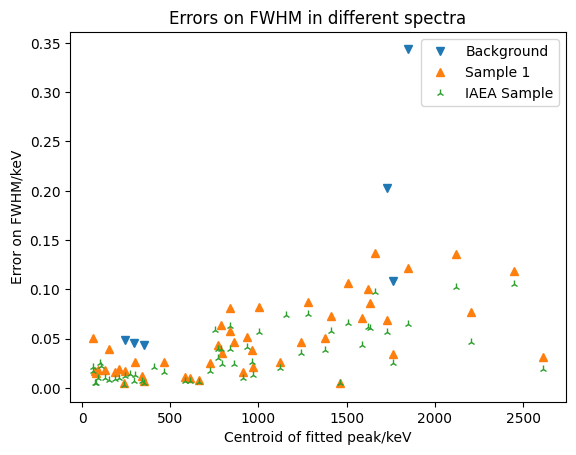

In [703]:
label_list = ['Background','Sample 1','Sample 2','Sample 3','Sample 4','IAEA Sample']
plt.figure()
plt.title(r'Errors on FWHM in different spectra')
for i in [0,1,5]:
    plt.plot(df.loc[i]['Centroid'], df.loc[i]['FWHM_err'],marker_list[3+i],label = label_list[i])
plt.legend()
plt.xlabel('Centroid of fitted peak/keV')
plt.ylabel(r'Error on FWHM/keV')
#plt.savefig('centroid_err.pdf')

Text(0, 0.5, 'Reduced $\\chi^2$')

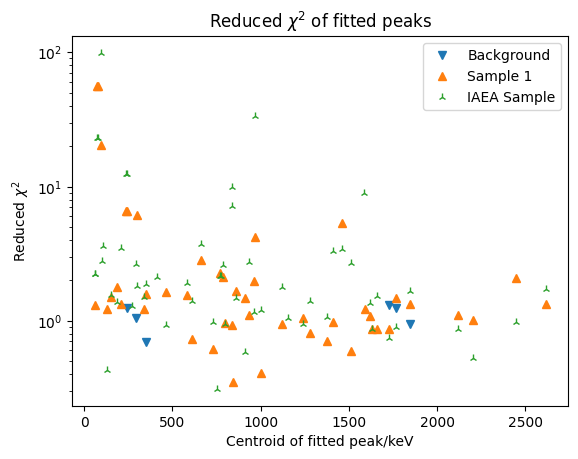

In [718]:
plt.figure()
plt.title(r'Reduced $\chi^2$ of fitted peaks')

for i in [0,1,5]:
    plt.plot(df.loc[i]['Centroid'], df.loc[i]['Reduced_chi2'],marker_list[3+i],label = label_list[i])
plt.legend()
plt.yscale('log')
plt.xlabel('Centroid of fitted peak/keV')
plt.ylabel(r'Reduced $\chi^2$')
#plt.savefig('reduced_chi2_gaussian.pdf')


FWHM of Gaussian = $2\sqrt{2\ln{2}}\sigma$, where $\sigma$ is standard deviation. \
Error in centroid of Gaussian can be given by standard error on mean, which is $\sigma/\sqrt{n}$. \
$n$ is the number of samples, i.e. total no. of counts under the peak in this  case

Loading peak data csv into pd.DataFrame

## Energy Calibration

In [690]:
#convert peak energy to channel number (fraction of channel number) using Lynx calibration
#Lynx calibration: energy = a * Ch^2 + b*Ch + c
a = 8.387880257e-8
b = 0.6775230169
c = -0.3439140022

energy_to_chan = lambda x : (-b + np.sqrt(b**2-4*a*(c-x)))/2/a #quadratic formula

# grad = 0.6775230169 #gradient
# interc = -0.3439140022 #intercept
# energy_to_chan = np.poly1d([1/grad,-interc/grad])


In [707]:
df_new

,Photopeak_Energy,Centroid,Nuclide,Net_Area_Count,Peak_CPS,FWHM,Reduced_chi2,rounded_energy,nuc,nndc_peak_energy,E_err,BR,BR_err,Centroid_err,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR
0,59.54,59.83,Am241,971.3,0.000812,0.75,2.26,60.0,Am241,59.5409,1.0E-4,0.35900,0.4,0.010219,0.017016,0.012536,0.000284,0.002263
1,63.29,63.71,Th234,1283.0,0.001073,1.07,2.26,63.0,Th234,63.2900,0.02,0.03700,0.4,0.012686,0.021123,0.016795,0.000332,0.029003
5,99.51,99.66,Ac228,1522.5,0.001273,1.41,2.79,100.0,Ac228,100.4100,0.03,0.01260,6.0E-4,0.015346,0.025552,0.014148,0.000256,0.101063
7,129.06,129.29,Ac228,2935.4,0.002455,0.75,2.88,129.0,Ac228,129.0650,0.97,0.02430,7.0E-4,0.005879,0.009788,0.005801,0.000076,0.101041
8,153.98,154.23,Ac228,1237.1,0.001035,0.41,1.77,154.0,Ac228,153.9770,0.1,0.00722,1.6E-4,0.004950,0.008243,0.002658,0.000053,0.143310
13,270.25,270.53,Ac228,4413.5,0.003692,1.34,2.26,270.0,Ac228,270.2450,0.002,0.03460,0.16E-5,0.008566,0.014263,0.004953,0.000053,0.106694
24,755.32,755.66,Ac228,561.6,0.000470,1.96,0.37,755.0,Ac228,755.3150,0.004,0.01000,0.1E-5,0.035122,0.058483,0.002594,0.000077,0.046972
33,934.06,934.41,Bi214,804.6,0.000673,1.67,2.73,934.0,Bi214,934.5000,0.5,0.03094,0.16E-5,0.025002,0.041630,0.001787,0.000045,0.021751
36,1000.99,1001.35,Pa234m,294.8,0.000247,1.38,1.94,1001.0,Pa234,1001.0300,0.1,0.00842,0.09E-6,0.034132,0.056833,0.001378,0.000057,0.029285
38,1155.19,1155.42,Bi214,465.9,0.000390,2.25,1.17,1155.0,Bi214,1155.2100,0.008,0.01634,0.4E-6,0.044267,0.073709,0.001947,0.000064,0.023849


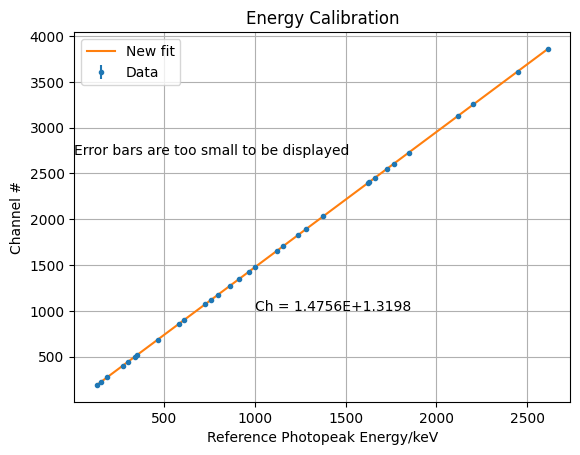

In [720]:
#df_new = df_1.dropna(subset = ['Photopeak_Energy']) #drop unidentified peaks
df_new = df.loc[5][df.loc[5]['Reduced_chi2']<2] #omit peaks with poor fit (reduced chi2 >3 )
x = df_new['nndc_peak_energy']
y = energy_to_chan(df_new['Centroid'])
popt_peak, pcov_peak = np.polyfit(x,y,1,cov = True) #energy callibration using peak
perr_peak = np.sqrt(np.diag(pcov_peak))
peak_fit = np.poly1d(popt_peak)
y_err = 1/np.sqrt(b**2-4*a*(c-x))*df_new['Centroid_err']
#errorbars are too small to be displayed
plt.title('Energy Calibration')
plt.errorbar(x,y,yerr= y_err, fmt = '.',label = 'Data')
plt.plot(x,peak_fit(x),label = 'New fit')
plt.legend()
plt.ylabel('Channel #')
plt.xlabel('Reference Photopeak Energy/keV')
plt.text(1000,1000,f'Ch = {popt_peak[0]:.4f}E+{popt_peak[1]:.4f}')
plt.text(1,2700,'Error bars are too small to be displayed')
plt.grid()
#plt.savefig('energy_calibration.pdf')

In [721]:
print(f'Linear fit (energy to channel) using peak energy: E = {1/popt_peak[0]:.6f}Ch {-popt_peak[1]/popt_peak[0]:.6f}')
print(f'Original quadratic fit (energy to channel) : E = {a:.6g}Ch^2 + {b:.6f}Ch + {c}' )
print('Errors on new fit:')
print(perr_peak)
chi2_prob(peak_fit(x),y,y_err,len(x)-2)
chi2_prob(energy_to_chan(x),y,y_err,len(x)-3)

Linear fit (energy to channel) using peak energy: E = 0.677713Ch -0.894474
Original quadratic fit (energy to channel) : E = 8.38788e-08Ch^2 + 0.677523Ch + -0.3439140022
Errors on new fit:
[6.31417119e-05 8.20496547e-02]
 chi2: 8910.202346715787 
 reduced chi2: 297.00674489052625
 chi2 p-value: 0.0
 chi2: 109426.13871119541 
 reduced chi2: 3773.3151279722556
 chi2 p-value: 0.0


(109426.13871119541, 3773.3151279722556, 0.0)

In [709]:
x[abs(y-energy_to_chan(x))>4]

Series([], Name: nndc_peak_energy, dtype: float64)

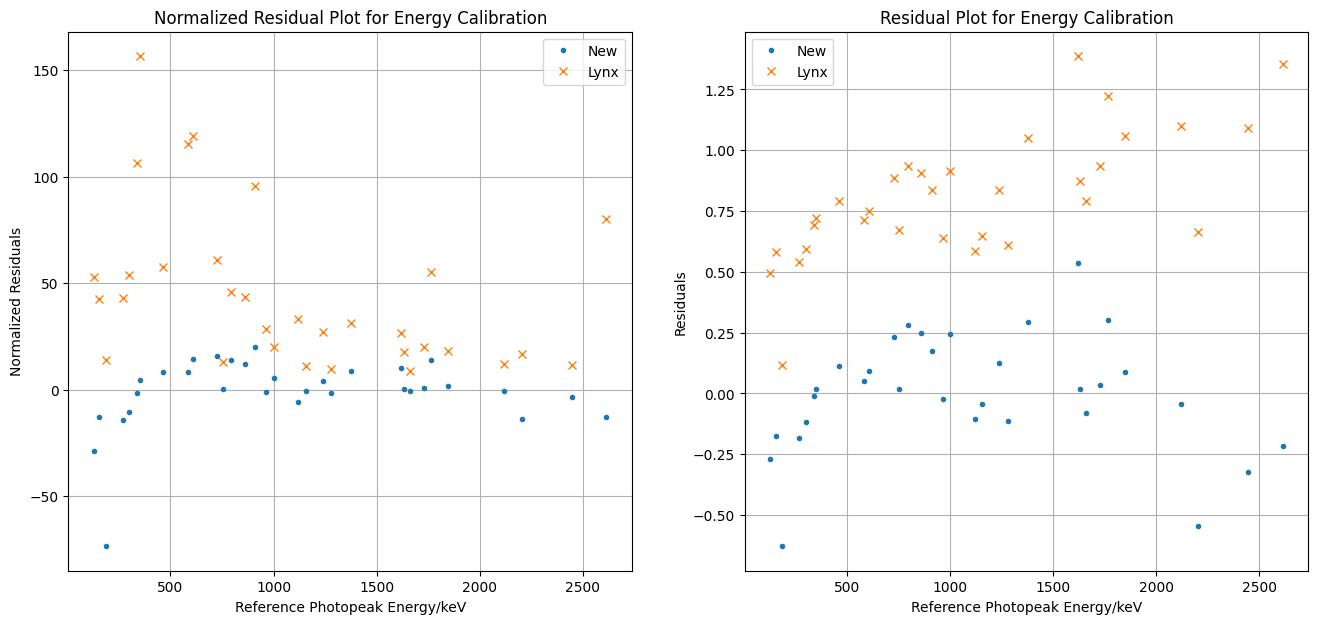

In [722]:
fig,ax = plt.subplots(1,2,figsize = (16,7))
ax[0].set_title('Normalized Residual Plot for Energy Calibration')
ax[0].plot(x,(y-peak_fit(x))/y_err,'.',label= 'New')
ax[0].plot(x,(y-energy_to_chan(x))/y_err,'x',label = 'Lynx')
ax[0].set_xlabel('Reference Photopeak Energy/keV')
ax[0].set_ylabel('Normalized Residuals')
ax[0].grid()
ax[0].legend()
ax[1].set_title('Residual Plot for Energy Calibration')
ax[1].plot(x,(y-peak_fit(x)),'.',label= 'New')
ax[1].plot(x,(y-energy_to_chan(x)),'x',label = 'Lynx')
ax[1].set_xlabel('Reference Photopeak Energy/keV')
ax[1].set_ylabel('Residuals')
ax[1].grid()
ax[1].legend()
plt.savefig('energy_norm_resid.pdf')

<ErrorbarContainer object of 3 artists>

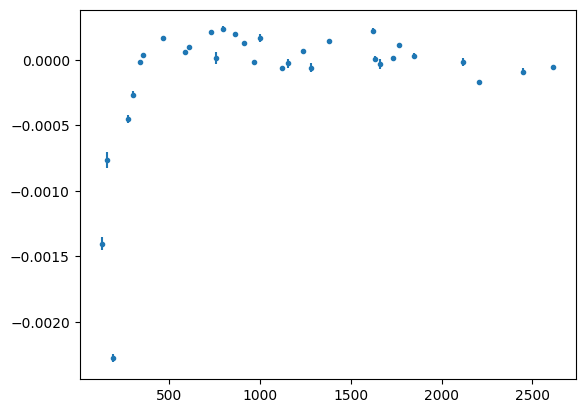

In [723]:
plt.errorbar(x,(y-peak_fit(x))/y,yerr= y_err/y,fmt = '.',label= 'New')

In [72]:
chi2_prob(y,peak_fit(x),y_err,len(x)-2)

 chi2: 2781.832628648044 
 reduced chi2: 79.48093224708698
 chi2 p-value: 0.0


(2781.832628648044, 79.48093224708698, 0.0)

## Resolution Calibration

Resolution = $\frac{FWHM}{E_0}$,
where $FWHM = \sqrt{a \times E_0+b}$, a

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


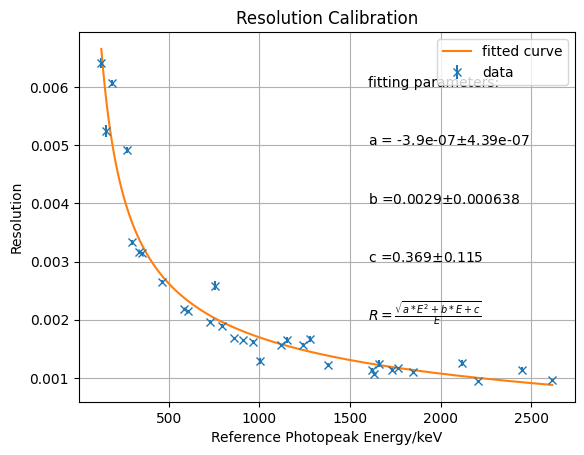

In [734]:
def res_fit(peak_energy,a,b):
    '''This function is used for fitting resolution as a function of energy
       res = np.sqrt(a*energy+b)/energy
       Input:  peak_energy - reference photopeak energy
               a,b         - parameters for the above formula
       Output: resolution
       '''
    return np.sqrt(a*peak_energy+b)/peak_energy

def res_fit_2(peak_energy,a,b,c):
    '''This function is used for fitting resolution as a function of energy
       res = np.sqrt(a*energy+b)/energy
       Input:  peak_energy - reference photopeak energy
               a,b         - parameters for the above formula
       Output: resolution
       '''
    return np.sqrt(a*peak_energy**2+b*peak_energy+c)/peak_energy

y_fwhm2 = df_new['FWHM']*df_new['FWHM']
p_fwhm2,cov_fwhm2 = np.polyfit(x,y_fwhm2, 2,cov = True)

x_res = df_new['nndc_peak_energy']
y_res = df_new['Resolution']
y_res_err = df_new['Resolution_err']
res_par, res_cov = curve_fit(res_fit_2,x_res,y_res, p0 = [0.00001,0.00055, 1.8])
res_fit_err = np.sqrt(np.diag(res_cov))
x_plot = np.linspace(min(x_res),max(x_res),500)

plt.figure()
plt.title('Resolution Calibration')
plt.errorbar(x_res,y_res,yerr = y_res_err,fmt = 'x',label = 'data')
plt.plot(x_plot,res_fit_2(x_plot,*res_par), label = 'fitted curve')
plt.ylabel('Resolution')
plt.xlabel('Reference Photopeak Energy/keV')
plt.legend()
plt.text(1600,0.006,f'fitting parameters:')
plt.text(1600,0.005,f'a = {res_par[0]:.3g}' + r'$\pm$'+ f'{res_fit_err[0]:.3g}')
plt.text(1600,0.004,f'b ={res_par[1]:.3g}' + r'$\pm$'+ f'{res_fit_err[1]:.3g}')
plt.text(1600,0.003,f'c ={res_par[2]:.3g}' + r'$\pm$'+ f'{res_fit_err[2]:.3g}')
plt.text(1600,0.002,r'$R = \frac{\sqrt{a * E^2+b*E+c}}{E}$')
plt.grid()
#plt.savefig('res_calibration.pdf')

In [736]:
fwhm2 = np.poly1d(p_fwhm2)(x)
print(res_par)
print(p_fwhm2)
print(np.sqrt(np.diag(cov_fwhm2)))
print(res_fit_err)
chi2_prob(fwhm2,y_fwhm2,2*df_new['FWHM']*df_new['FWHM_err'],len(x)-3)
chi2_prob(res_fit_2(x,*res_par),y_res,y_res_err,len(x)-3)

[-3.89933347e-07  2.90009910e-03  3.69410774e-01]
[3.33063251e-07 1.48482427e-03 7.97275435e-01]
[2.73520548e-07 7.11495389e-04 3.84496604e-01]
[4.38574396e-07 6.37692815e-04 1.14829103e-01]
 chi2: 1718.6037312912222 
 reduced chi2: 59.2621976307318
 chi2 p-value: 0.0
 chi2: 2254.2821105071785 
 reduced chi2: 77.73386587955788
 chi2 p-value: 0.0


(2254.2821105071785, 77.73386587955788, 0.0)

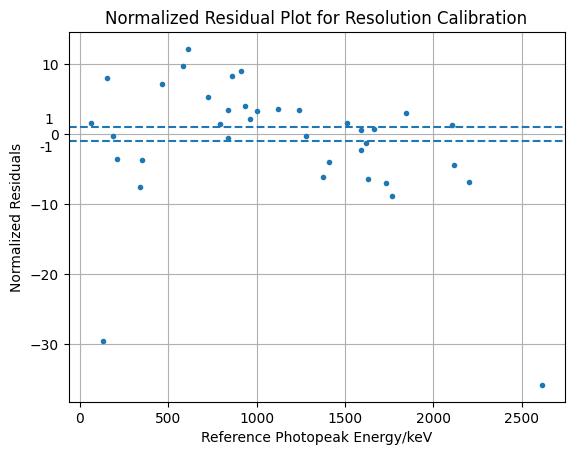

In [185]:
plt.figure()
plt.title('Normalized Residual Plot for Resolution Calibration')
plt.plot(x_res,(y_res-res_fit_2(x_res,*res_par))/y_err_res,'.')
plt.xlabel('Reference Photopeak Energy/keV')
plt.ylabel('Normalized Residuals')
plt.grid()
plt.axhline(1,linestyle = '--')
plt.axhline(-1,linestyle = '--')
plt.text(-150, 1, '1', ha='right', va='bottom')
plt.text(-150, -1, '-1', ha='right', va='top')
plt.savefig('res_norm_resid.pdf')

In [173]:
chi2_prob(y_res,res_fit_2(x_res,*res_par),y_err_res,len(x_res)-2)

 chi2: 3152.7349824756625 
 reduced chi2: 90.0781423564475
 chi2 p-value: 0.0


(3152.7349824756625, 90.0781423564475, 0.0)

In [76]:
df_new['Nuclide'].unique()

array(['Th234', 'Ac228', 'Ra226', 'Pb214', 'Tl208', 'Bi214', 'Bi212',
       'Pa234m', 'Tl208 (D.E.)', 'Tl208 (S.E.)'], dtype=object)

### Plots of counts / branching ratio of nuclides at different energies

In [77]:
df = df_new
df = df[df['Nuclide']=='Bi212']
#plt.plot(df['Photopeak_Energy'],df['Peak_CPS_BR'])
df['BR']

22   NaN
44   NaN
Name: BR, dtype: float64

In [92]:
df_2[df_2['Nuclide']=='Bi212'][['Centroid','Photopeak_Energy']]

,Centroid,Photopeak_Energy
25,727.40,727.33
50,1620.76,1620.50


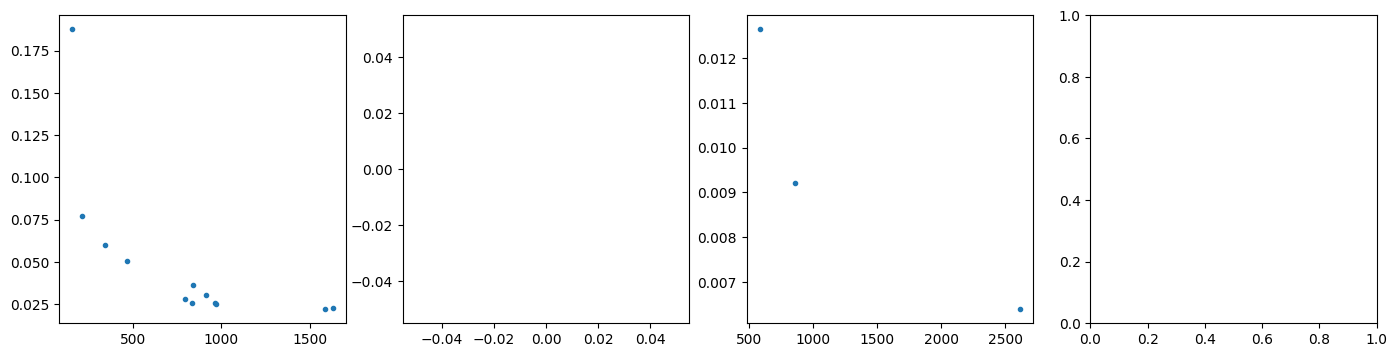

In [78]:
U238_chain = ['Th234','Pa234m','Ra226','Pb214','Bi214']
Th232_chain = ['Ac228','Bi212','Tl208']
def rel_activity(df0,chain):
        fig,ax = plt.subplots(1,4,figsize = (17,4))
        i = 0
        for nuclide in chain:
                df = df0[df0['Nuclide']==nuclide].dropna(subset = 'Peak_CPS_BR')
                ax[i].plot(df['Photopeak_Energy'],df['Peak_CPS_BR'],'.')
                i +=1
        plt.show()
        
rel_activity(df_1,Th232_chain)

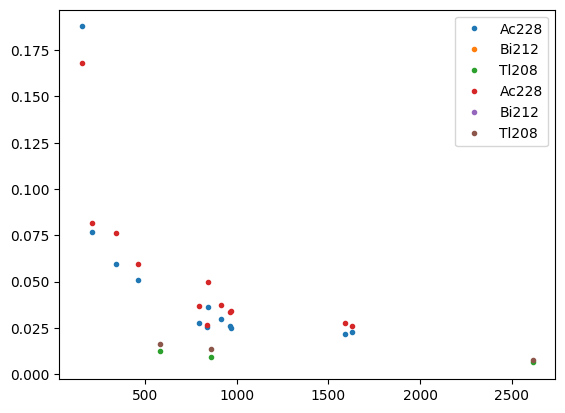

In [96]:
plt.figure()
i = 0

for nuclide in Th232_chain:
    df = df_1[df_1['Nuclide']==nuclide].dropna(subset = 'Peak_CPS_BR')
    plt.plot(df['Photopeak_Energy'],df['Peak_CPS_BR'],'.',label = nuclide )
    i +=1
    plt.legend()
for nuclide in Th232_chain:
    df = df_2[df_2['Nuclide']==nuclide].dropna(subset = 'Peak_CPS_BR')
    plt.plot(df['Photopeak_Energy'],df['Peak_CPS_BR'],'.',label = nuclide )
    i +=1
    plt.legend()
    


In [156]:
diff = df_1['Centroid'][1:].to_numpy()-df_1['Centroid'][:-1].to_numpy()
df_1[:-1][diff<3*df_1['FWHM'][:-1].to_numpy()]['Reduced']

1     56.12
32     1.97
42     1.23
Name: Reduced, dtype: float64

In [177]:
def compton_edge(energy):
    ratio = energy/511 #energy to electron rest energy  ratio
    return energy*(2*ratio/(2*ratio+1))
compton_edge(1460.75)
compton_edge(2614.53)

2381.7754939495408

In [202]:
import requests
from bs4 import BeautifulSoup

Intensity / 100 = Branching ratio (BR)

In [353]:
df_1[df_1['Nuclide'].str.contains('Pa234').fillna(False)]

,Centroid,Net_Area_Count,Net_Area,Peak_CPS,FWHM,FWHM,Reduced,ROI_Total,ROI,File,...,Color,User_Label,Continuum_Type,BR,Dose,Centroid_err,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR
24,786.45,315.1,42.8,0.000535,1.60,0.20%,2.12,8952.3,25,,...,#FF6633,NaN,Linear,NaN,NaN,0.038277,0.063735,0.002034,0.000081,NaN
34,1002.13,224.1,42.2,0.000380,1.75,0.17%,0.41,5574.0,35,,...,#FF6633,NaN,Linear,NaN,NaN,0.049643,0.082661,0.001746,0.000082,NaN


In [349]:
df_1['Nuclide'].dropna().str.findall('\w+\d+')

0     [Th234]
1     [Pb212]
2     [Pb212]
3     [Th234]
4     [Ac228]
5     [Ac228]
6     [Ra226]
7     [Ac228]
8     [Pb212]
9     [Pb214]
12    [Pb212]
14    [Ac228]
15    [Pb214]
17    [Ac228]
19    [Tl208]
20    [Bi214]
21    [Cs137]
22    [Bi212]
23    [Bi214]
24    [Pa234]
25    [Ac228]
26    [Ac228]
27    [Ac228]
28    [Tl208]
29    [Ac228]
30    [Bi214]
32    [Ac228]
33    [Ac228]
34    [Pa234]
35    [Bi214]
36    [Bi214]
37    [Bi214]
38    [Bi214]
39    [Bi214]
40      [K40]
41    [Bi214]
42    [Ac228]
43    [Tl208]
44    [Bi212]
45    [Ac228]
46    [Bi214]
47    [Bi214]
48    [Bi214]
49    [Bi214]
50    [Tl208]
51    [Bi214]
52    [Bi214]
53    [Bi214]
54    [Tl208]
Name: Nuclide, dtype: object

In [345]:
nuc = df_1['Nuclide'].dropna()
nuc = list(set([i[0] for i in nuc.str.findall('\w+\d+')])) #unique nuclide names
nuc

['Bi212',
 'K40',
 'Pb214',
 'Pa234',
 'Tl208',
 'Bi214',
 'Ac228',
 'Th234',
 'Pb212',
 'Cs137',
 'Ra226']

In [362]:
nndc_df.dtypes

A                       int64
Element                object
Z                       int64
N                       int64
Par. Elevel           float64
Unc.                   object
JPi                    object
Dec Mode               object
T1/2 (txt)             object
T1/2 (num)              int64
Daughter               object
Radiation              object
Rad subtype            object
Photopeak_Energy      float64
E_err                  object
EP Ene.                object
Unc       .1           object
Rad Int.              float64
BR_err                 object
Dose                  float64
Unc       .3           object
BR                    float64
dtype: object

In [332]:
#rename nndc columns
nndc_col = {'Rad Ene.  ' : 'Photopeak_Energy','Unc       .2':'BR_err','Unc       ':'E_err'} 
nndc_df.rename(columns = nndc_col,inplace=True)
#adding branching ratios of gamma rad. from electron capture and other pathways of the same energy
nndc_df['BR'] = nndc_df.groupby(['Photopeak_Energy'])['Rad Int.  '].transform('sum')/100 #BR = intensity/100
nndc_df['BR_err'] = nndc_df['BR_err']/100
pd.merge(df_1[df_1['Nuclide'] == 'Bi212'],nndc_df[['Photopeak_Energy','E_err','BR','BR_err']], on = 'Photopeak_Energy',how = 'left').drop_duplicates(subset = 'Photopeak_Energy')

,Centroid,Net_Area_Count,Net_Area,Peak_CPS,FWHM,FWHM,Reduced,ROI_Total,ROI,File,...,BR_x,Dose,Centroid_err,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR,E_err,BR_y,BR_err
0,728.00,1449.7,63.5,0.002460,1.38,0.19%,0.61,7218.9,23,,...,NaN,NaN,0.015392,0.025629,0.001896,0.000035,NaN,0.009,0.0667,0.09
1,1621.52,229.0,29.7,0.000389,2.14,0.13%,1.08,1532.8,45,,...,NaN,NaN,0.060053,0.099996,0.001320,0.000062,NaN,0.1,0.0147,0.05E-6


In [322]:
len(nndc_df)

152

In [281]:
df_1['Photopeak_Energy']

0       62.86
1       74.82
2       77.11
3       92.80
4      129.06
5      153.98
6      186.21
7      209.25
8      238.63
9      242.00
10        NaN
11        NaN
12     300.09
13        NaN
14     338.32
15     351.93
16        NaN
17     463.00
18        NaN
19     583.19
20     609.31
21     661.66
22     727.33
23     768.36
24     786.25
25     794.95
26     835.71
27     840.38
28     860.56
29     911.20
30     934.06
31        NaN
32     964.77
33     968.97
34    1000.99
35    1120.29
36    1238.11
37    1280.96
38    1377.67
39    1407.98
40    1460.75
41    1509.23
42    1588.20
43    1592.54
44    1620.50
45    1630.63
46    1661.28
47    1729.59
48    1764.49
49    1847.42
50    2103.53
51    2118.55
52    2204.21
53    2447.86
54    2614.53
Name: Photopeak_Energy, dtype: float64

In [310]:
pd.merge(df_1[df_1['Nuclide'] == 'Bi212'],nndc_df[['Photopeak_Energy','Rad Int.  ']], on = 'Photopeak_Energy',how = 'left')

,Centroid,Net_Area_Count,Net_Area,Peak_CPS,FWHM,FWHM,Reduced,ROI_Total,ROI,File,...,User_Label,Continuum_Type,BR,Dose,Centroid_err,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR,Rad Int.
0,728.00,1449.7,63.5,0.002460,1.38,0.19%,0.61,7218.9,23,,...,NaN,Linear,NaN,NaN,0.015392,0.025629,0.001896,0.000035,NaN,6.67
1,1621.52,229.0,29.7,0.000389,2.14,0.13%,1.08,1532.8,45,,...,NaN,Linear,NaN,NaN,0.060053,0.099996,0.001320,0.000062,NaN,1.47


In [297]:
df_1[df_1['Nuclide'] == 'Bi212']

,Centroid,Net_Area_Count,Net_Area,Peak_CPS,FWHM,FWHM,Reduced,ROI_Total,ROI,File,...,Color,User_Label,Continuum_Type,BR,Dose,Centroid_err,FWHM_err,Resolution,Resolution_err,Peak_CPS_BR
22,728.00,1449.7,63.5,0.002460,1.38,0.19%,0.61,7218.9,23,,...,#FF66FF,NaN,Linear,NaN,NaN,0.015392,0.025629,0.001896,0.000035,NaN
44,1621.52,229.0,29.7,0.000389,2.14,0.13%,1.08,1532.8,45,,...,#FF66FF,NaN,Linear,NaN,NaN,0.060053,0.099996,0.001320,0.000062,NaN


In [309]:
pd.unique(nndc_df[['Photopeak_Energy']].values.ravel())
nndc_df.drop_duplicates(subset = "Photopeak_Energy",inplace = True)

In [282]:
nndc_df.rename( columns = {'Rad Ene.  ' : 'Photopeak_Energy','Unc       .2':'BR_err','Unc       ':'E_err'},inplace=True)

In [286]:
nndc_df[['Photopeak_Energy','Rad Int.  ']]

,Photopeak_Energy,Rad Int.
0,5750.00,0.47000
1,6010.00,5.00000
2,6300.00,26.00000
3,6340.00,35.00000
4,5302.00,0.00004
...,...,...
147,1078.62,0.56400
148,1512.70,0.29000
149,1620.50,1.47000
150,1679.70,0.05800


In [303]:
nndc_df.columns

Index(['A  ', 'Element', 'Z  ', 'N  ', 'Par. Elevel', 'Unc. ', 'JPi       ',
       'Dec Mode', 'T1/2 (txt)    ', 'T1/2 (num)        ', 'Daughter',
       'Radiation', 'Rad subtype ', 'Photopeak_Energy', 'Unc       ',
       'EP Ene.   ', 'Unc       .1', 'Rad Int.  ', 'Unc       .2',
       'Dose        ', 'Unc       .3'],
      dtype='object')